# SplineCalib: The dirty details
In this notebook, we dive into the various "knobs" of SplineCalib.  While the default settings generally work very well, in some situations the user may want to make some specific adjustments to the spline fitting process.  This notebook will walk through several examples where we may want to adjust the default behavior and thereby provide a deeper understanding of the details of how SplineCalib works.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ml_insights as mli

from sklearn.metrics import roc_auc_score, log_loss

In [2]:
## This is a (rather ugly) function that allows us 
## to make piecewise linear functions easily

def make_pw_linear_fn(xvals, yvals):
    def lin_func(x):
        if type(x)==np.ndarray:
            return(np.array([lin_func(i) for i in x]))
        
        if x<=xvals[0]:
            return(yvals[0])
        elif x>=xvals[-1]:
            return(yvals[-1])
        else:
            asd=np.max(np.where(x>xv)[0])
            return(yv[asd]+((x-xv[asd])*(yv[asd+1]-yv[asd])/(xv[asd+1]-xv[asd])))
    return lin_func

In [3]:
## If we specify a set of x_values and y values it returns a function 
## that linearly interpolates between them on the domain specified
xv = np.array([0,.1,.4,.7,.9,1])
yv = np.array([0,.4,.7,.8,.95,1])
f1 = make_pw_linear_fn(xv,yv)

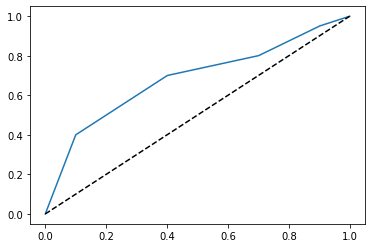

In [4]:
# Here's what the resulting function looks like
# We will use this below to represent the "true" calibration function
# In other words, when x is our model output, f1(x) will be the 
# true probability that y=1 given x
tvec = np.linspace(0,1,1001)
plt.plot(tvec,f1(tvec))
plt.plot(tvec,tvec,'k--')

We generate some synthetic data.

`xvec` representes the uncalibrated scores

`probvec` represents the true probability for that score

`yvec` is the binary outcome based on the true probability

Given xvec and yvec, we wish to recover an estimate of 
the function `f1` that we defined above
which maps scores to true probabilities

In [5]:
np.random.seed(0)
npts = 5000
xvec = np.random.uniform(size =npts)
probvec = f1(xvec)
yvec = np.random.binomial(n=1, p=probvec)

In [6]:
xvec_test = np.random.uniform(size=50000)
probvec_test = f1(xvec_test)
yvec_test = np.random.binomial(n=1, p=probvec_test)

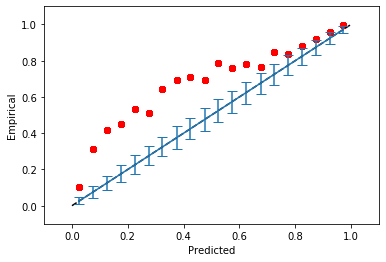

In [7]:
# From this reliability diagram, we see that our scores
# are underpredicting the true probability
mli.plot_reliability_diagram(yvec,xvec);

In [8]:
# We use a SplineCalib with the default settings and fit it to the calibration data
sc = mli.SplineCalib()
sc.fit(xvec, yvec)

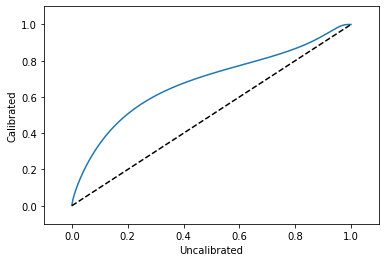

In [9]:
# Here is the resulting calibration curve

sc.show_calibration_curve()

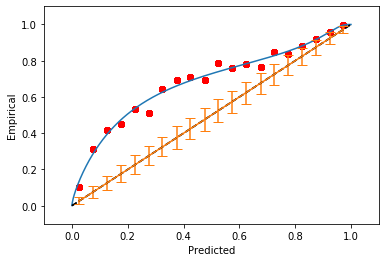

In [10]:
# Here is the calibration curve superimposed on the reliability diagram
# We see it fits the data well without being overly wiggly
sc.show_calibration_curve()
mli.plot_reliability_diagram(yvec,xvec);

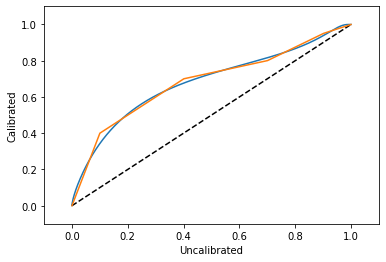

In [11]:
# Here is the calibration curve compared to the "true" answer
# We see it fits well, though it "rounds off" the corners
# This is by design, the splines are required to have a continuous
# first (and second) derivative
sc.show_calibration_curve()
plt.plot(tvec, f1(tvec))

In [12]:
# Here we see that the log_loss of our calibrated probabilities
# are nearly as good as using the actual "right answer"
# and a large improvement over the uncalibrated probabilities
(log_loss(yvec_test, xvec_test), 
 log_loss(yvec_test, sc.calibrate(xvec_test)), 
 log_loss(yvec_test, f1(xvec_test)))

(0.6133973712076545, 0.5031396933529355, 0.5016643670451323)

In [13]:
# Note that the AUROC score does not change.
# This will *always* be the case (as long as the calibration curve is increasing)
# Because AUROC just depends on the relative ordering of the scores

(roc_auc_score(yvec_test, xvec_test), 
 roc_auc_score(yvec_test, sc.calibrate(xvec_test)), 
 roc_auc_score(yvec_test, f1(xvec_test)))

(0.7817886328863712, 0.7817886328863712, 0.7817886328863712)

### Section 2: Changing the "reg_param" search
SplineCalib uses the sklearn LogisticRegression "under the hood".  Spline Calibration works by using a natural spline basis representation and then fitting an L2-regularized Logistic Regression.  We use cross-validation to find the best `C` parameter, where `C` is the inverse of the `lambda` parameter you may be familiar with in penalized regression methods.  Smaller `C` means a higher penalty on "wiggliness".  By default, SplineCalib looks at 17 equally spaced points (in log10 scale) between -4 and 4.

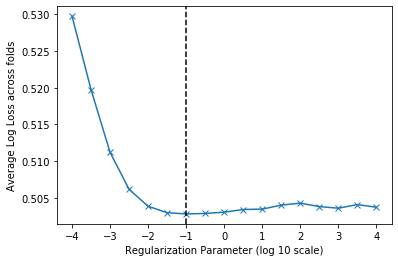

In [14]:
# This is a diagnostic tool which shows the cross-validation results
# used to choose the best regularization parameter
sc.show_spline_reg_plot()

In [15]:
sc.best_reg_param, np.log10(sc.best_reg_param)

(0.1, -1.0)

Above, we see that the best value was found when `C`=1e-1 or .1.  But perhaps there would be an even better value if we searched a finer "grid" of points.  In the next cell we will do exactly that.

In [16]:
# Search 51 points between 10**-2 and 10**0
sc1 = mli.SplineCalib(reg_param_vec = np.logspace(-2,0,51))
sc1.fit(xvec, yvec)

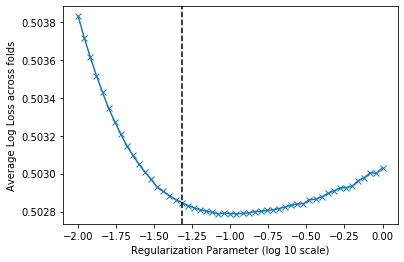

In [17]:
# Now we explore just the range 1e-2 to 1e0 with more resolution
sc1.show_spline_reg_plot()

In [18]:
sc1.best_reg_param, np.log10(sc1.best_reg_param)

(0.04786300923226385, -1.3199999999999998)

Why didn't we chooose the minimum value?!  By default SplineCalib errs on the side of more regularization and less "wiggly" curves.  One way it does this is to round the log_loss values to 4 decimals, and then choose the most regularized variant that achieves the (rounded) minimum.  So what we are seeing is that the dotted line achieves a value around .50284, which rounds down to .5028, and nothing else achieves less than .50275.  So many values get a rounded score of .5028, and SplineCalib chooses the leftmost (most regularized) one.

What if we want the absolute lowest one?  We can adjust the number of decimal places we look at using the `reg_prec` parameter.  The default value is 4, but we can make it higher if we wish to.  We give an example below.

In [19]:
# We can "focus" our regularization parameter in a narrower range to 
# try to get a more accurate "best" parameter
sc2 = mli.SplineCalib(reg_param_vec = np.logspace(-2,0,51), reg_prec=16 )
sc2.fit(xvec, yvec)

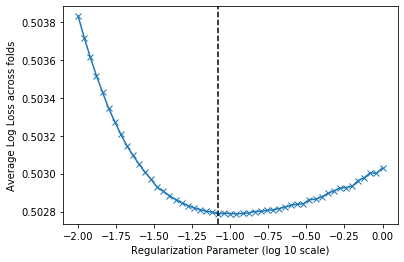

In [20]:
sc2.show_spline_reg_plot()

In [21]:
sc2.best_reg_param, np.log10(sc2.best_reg_param)

(0.08317637711026708, -1.08)

In [22]:
# We can see the underlying scores here
sc2.reg_param_scores

array([0.50383046, 0.50371693, 0.50361335, 0.50351697, 0.50342938,
       0.50334503, 0.50327488, 0.50320792, 0.50314713, 0.50309622,
       0.50304933, 0.50300662, 0.50296915, 0.50292768, 0.50290634,
       0.50288332, 0.50286315, 0.50284692, 0.50283124, 0.50281987,
       0.50280988, 0.50280178, 0.50279629, 0.50278729, 0.50279108,
       0.5027892 , 0.50278771, 0.50278984, 0.50279274, 0.50279985,
       0.50280044, 0.50280589, 0.50280883, 0.50281549, 0.50282396,
       0.502833  , 0.50283894, 0.5028411 , 0.50286308, 0.50286438,
       0.50287732, 0.50289526, 0.5029087 , 0.50292372, 0.50292643,
       0.50293301, 0.50296297, 0.50297888, 0.50300407, 0.50300178,
       0.50303074])

The differences between the three calibrators is nearly imperceptible...


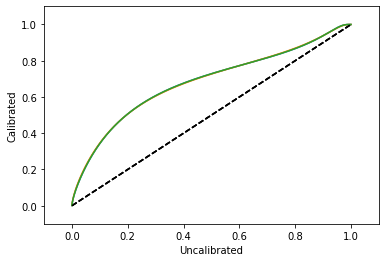

In [23]:
sc.show_calibration_curve()
sc1.show_calibration_curve()
sc2.show_calibration_curve()

In [24]:
(log_loss(yvec_test, sc.calibrate(xvec_test)), 
 log_loss(yvec_test, sc1.calibrate(xvec_test)), 
 log_loss(yvec_test, sc2.calibrate(xvec_test)))

(0.5031396933529355, 0.5030895665597304, 0.5031236086063988)

## Section 3: The `logodds_eps` parameter

In the next couple of sections, we will imagine that we have only a small set of points from which to learn our calibration.  This situation may require us to do some manual tinkering to achieve the best results, though the default should still give a reasonable calibration.

In [25]:
np.random.seed(0)
npts = 100
xvec = np.random.uniform(size =npts)
probvec = f1(xvec)
yvec = np.random.binomial(n=1, p=probvec)

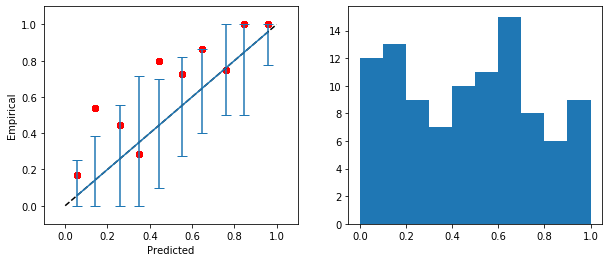

In [26]:
# Here we plot a reliablity diagram with custom bins (10 equally spaced).
# Since we have only 100 data points it is hard to see much of a pattern
# except that most points seem above the line.

plt.figure(figsize=(10,4))
mli.plot_reliability_diagram(yvec,xvec, bins=np.linspace(0,1,11), show_histogram=True);

In [27]:
# Try SplineCalib with the default settings
sc4 = mli.SplineCalib()
sc4.fit(xvec, yvec)

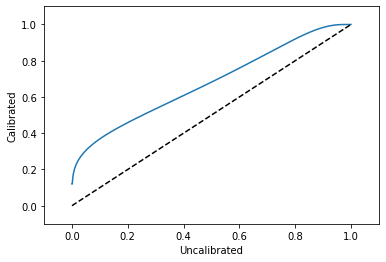

In [28]:
# Here is the resulting calibration curve
sc4.show_calibration_curve()

In [29]:
# The curve does not go to [0,0], let's investigate...

sc4.calibrate(np.array([0,1e-16,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]))

array([0.11966725, 0.11966725, 0.11966725, 0.11966725, 0.11966725,
       0.11966725, 0.11966725, 0.11966725, 0.11966725, 0.11966725,
       0.20690302])

In [30]:
sc4.logodds_eps, np.min(xvec)

(0.001, 0.004695476192547066)

What's going on here?  Well, it's a bit complicated....

By default, SplineCalib transforms the "incoming" probabilities to log-odds scale before doing the spline basis expansion and subsequent logistic regression.  This is generally the "right" thing to do, however, it poses a problem, as 0 and 1 map to -infinity and +infinity respectively.  So what should we do?

Our solution is to designate a parameter $\epsilon$, and then map everything smaller than $\epsilon$ to $\epsilon$ (and everything larger than ($1-\epsilon$) to ($1-\epsilon$)).

There are several justifications for this, but perhaps the most useful is to assume that probabilities are **never** 0 or 1.  And even if, say, a random forest model gives a "probability" of 0 (meaning no trees thought this was a positive case), there is almost certainly some probability that it will indeed be a positive case.

So what should be the value of $\epsilon$ or, as we refer to it `logodds_eps`?  By default, SplineCalib will choose a "reasonable" value.  It does so based on two principles:

1. 0 should be qualitatively different from the smallest positive value we see in our data set.  So if we see a value of .0001 in our training data, `logodds_eps` should be less than that, so as not to "aggregate" the two different kinds of scores.

2. There should not be a huge gap between where 0 lies after transformation and the next highest value lies.  It may be tempting to set `logodds_eps` at 1e-16, but in practice, this may cause issues since zeros will have high "leverage" in the logistic regression.

Thus, by default, SplineCalib uses a heuristic which says, essentially, if the smallest positive value is 1e-4, then set `logodds_eps` to be 1e-5.

(Note: The above principles and reasoning apply analogously to values close to 1, and SplineCalib considers both values close to zero and close to one in choosing `logodds_eps`)

If you wish to override this, you can easily do so by setting `logodds_eps` manually.


In [31]:
# the smalles value of xvec was .0047, so logodds_eps was set at .001
sc4.logodds_eps, np.min(xvec)

(0.001, 0.004695476192547066)

In [32]:
# So, all values <=.001 get the same value (.1197)

sc4.calibrate(np.array([0,1e-16,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]))

array([0.11966725, 0.11966725, 0.11966725, 0.11966725, 0.11966725,
       0.11966725, 0.11966725, 0.11966725, 0.11966725, 0.11966725,
       0.20690302])

In [33]:
sc5 = mli.SplineCalib(logodds_eps=.0000001)
sc5.fit(xvec, yvec)

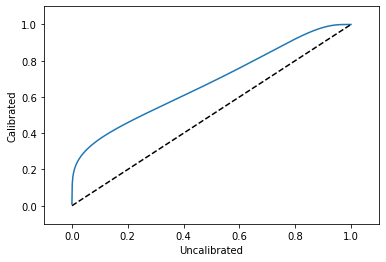

In [34]:
sc5.show_calibration_curve()

In [35]:
sc5.logodds_eps, np.min(xvec)

(1e-07, 0.004695476192547066)

In [36]:
sc5.calibrate(np.array([0,1e-16,1e-8,1e-4,1e-3,1e-2]))

array([0.01009051, 0.01009051, 0.01009051, 0.06639844, 0.11966725,
       0.20690302])

Note, that it is debatable whether or not this behavior is desirable.  We have no data for inputs < .0046, so the question is how far we should "extrapolate" and the extent to which we should assume that the true probability approaches 0 as the input goes to zero.

In [37]:
# Negligible difference in performance on the test set
(log_loss(yvec_test, sc4.calibrate(xvec_test)),
log_loss(yvec_test, sc5.calibrate(xvec_test)) )

(0.5153038762629203, 0.5152873082801882)

## Section 4: The **unity_prior**
Often, when dealing with small calibration training sets, it is useful to use a "unity" prior distribution.  This means that, before we see any data, we assume that the input distribution is (relatively) well-calibrated, and we put a "weight" (measured in number of observations) on that belief.

In SplineCalib, we control this with the parameters `unity_prior`, `unity_prior_weight`, and `unity_prior_gridsize`.  Setting `unity_prior` to True, will augment the training data with observations along the axis y=x.  `unity_prior_weight` controls the "strength" of the prior, measured in number of observations.  `unity_prior_gridsize` controls the resolution of the augmented points.  We deomstrate this below:


In [38]:
# Take the previous calibration curve and add a unity prior with weight 50
sc6 = mli.SplineCalib(unity_prior=True, 
                      unity_prior_weight=25,
                      logodds_eps=.0000001)
sc6.fit(xvec, yvec)

/Users/brianlucena/.pyenv/versions/3.7.3/envs/mypy373/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/brianlucena/.pyenv/versions/3.7.3/envs/mypy373/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/brianlucena/.pyenv/versions/3.7.3/envs/mypy373/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [39]:
# We get a warning about lack of convergence.  This is usually not a problem, but can
# usually be fixed by increasing the number of iterations via "max_iter"

sc6 = mli.SplineCalib(unity_prior=True,
                      unity_prior_weight=25,
                      logodds_eps=.0000001, max_iter=5000)
sc6.fit(xvec, yvec)

In [40]:
# Now increase the weight to 100
sc7 = mli.SplineCalib(unity_prior=True,
                      unity_prior_weight=100,
                      logodds_eps=.0000001, max_iter=5000)
sc7.fit(xvec, yvec)

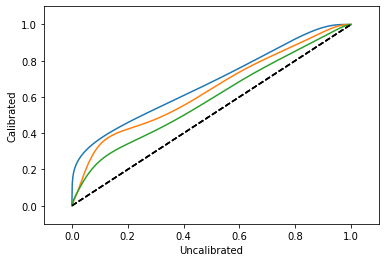

In [41]:
# We see that the curve gets closer to the line y=x as we increase the 
# weight of the unity prior
sc5.show_calibration_curve()
sc6.show_calibration_curve()
sc7.show_calibration_curve()

In [42]:
# Adding unity prior of weight 25 slight improves the test set performance in this case
# Adding unity priot of weight 100 makes it considerably worse
# Recall that our training data was size 100

(log_loss(yvec_test, sc5.calibrate(xvec_test)), 
 log_loss(yvec_test, sc6.calibrate(xvec_test)), 
 log_loss(yvec_test, sc7.calibrate(xvec_test)))

(0.5152873082801882, 0.5126795320612005, 0.5318435540073075)

### Section 5: How to choose the knots
One key aspect of spline fitting methods is how to choose the "knots".  Recall that a natural cubic spline is defined as a different cubic function on each interval, with additional contraints so that the first and second derivatives remain continuous as we cross from one interval to another.  The "knots" are the endpoints of the intervals and thereby greatly affect how the spline is fit.

The traditional smoothing spline uses **all** of the observed x-values as knots and relies on the regularization to prevent the spline from becoming too wiggly.  However, in practice, using all values adds significantly to the time complexity of the spline-fitting without markedly improving the performance.  Consequently, by default, SplineCalib randomly chooses 30 knots, and forces the smallest and largest values to be knots (so technically we choose 28 knots at random from the "interior" values and add in the smallest and largest).  We find that this works well in practice.

However, we also give the user control in how to choose the knots.  Users can increase the size of the randomly sampled knots, force the inclusion of endpoints, and, in fact, force the inclusion of any specified values.  This is controlled by the following parameters:

`knot_sample_size`: The size of the random sample of x-values used as knots.  If `force_knot_endpts` is True, the smallest and largest values will be chosen as knots automatically, and `knot_sample_size`-2 additional knots will be chosen at random from the other values.  Default is 30

`force_knot_endpts`: If True, the smallest and largest input values will automatically be included in the (random) knot sample.  If False, this will not be done.  Default is True.

`add_knots`: A list or np-array of additional knots to be used.  If the user wishes to directly specify knots, they can set `knot_sample_size` to 0 and give the knots they wish to use in `add_knots`.

To demonstrate some of these features, we create a dataset where values that are greater than 0.6 are rare in the input data.  Thus if you rely on purely random selection, this area will be underrepresented in the knots.  This may or may not be desirable, depending on other factors.

In [43]:
# Generate data as before
np.random.seed(0)
npts = 5000
xvec = np.random.uniform(size =npts)
probvec = f1(xvec)
yvec = np.random.binomial(n=1, p=probvec)

# Filter out 95% of the values where xvec is greater than 0.6
keep_pt = np.random.uniform(size=len(xvec))<.05
mask = (xvec<=.6) | (keep_pt==1)
xvec = xvec[mask]
yvec = yvec[mask]

len(xvec), np.min(xvec), np.max(xvec)

(3134, 7.2449638492178e-05, 0.9904533093614852)

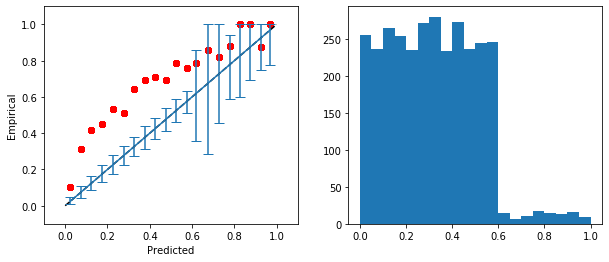

In [44]:
# The histogram shows the paucity of data greater than 0.6
plt.figure(figsize=(10,4))
mli.plot_reliability_diagram(yvec, xvec,show_histogram=True);

In [45]:
# First, let's try the default SplineCalib parameters
sc8 = mli.SplineCalib()
sc8.fit(xvec, yvec)

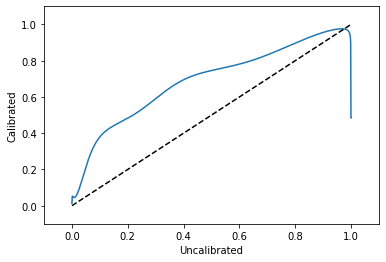

In [46]:
sc8.show_calibration_curve()

In [47]:
sc8.knot_vec, len(sc8.knot_vec)

(array([7.24496385e-05, 3.86648424e-03, 1.49762602e-02, 6.80930992e-02,
        7.45300840e-02, 8.96424761e-02, 1.29141352e-01, 1.58969584e-01,
        2.26196301e-01, 2.43937790e-01, 2.57958778e-01, 2.63767686e-01,
        2.74823570e-01, 2.92794031e-01, 2.93991253e-01, 3.04173557e-01,
        3.24599999e-01, 3.74296183e-01, 3.92692307e-01, 4.08302908e-01,
        4.14661940e-01, 4.20353809e-01, 4.32279581e-01, 4.73385726e-01,
        4.90966386e-01, 5.34508940e-01, 5.43678054e-01, 6.39186899e-01,
        9.45301533e-01, 9.90453309e-01]), 30)

In [48]:
# Lets try 30 equally spaced knots from 0 to 1
sc9= mli.SplineCalib(knot_sample_size = 0, force_knot_endpts=False,
                     add_knots = np.linspace(0,1,30))
sc9.fit(xvec, yvec)

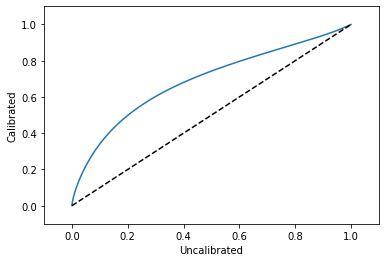

In [49]:
# Looks smoother

sc9.show_calibration_curve()

In [50]:
sc9.knot_vec, len(sc9.knot_vec)

(array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]), 30)

In [51]:
# neglible difference in performance on test set (is slightly worse)
# However, gives a more "coherent" curve

(log_loss(yvec_test, sc8.calibrate(xvec_test)), 
 log_loss(yvec_test, sc9.calibrate(xvec_test)))

(0.5034215450761254, 0.5039773750126008)

In [52]:
# let's force the endpoints, choose 17 additional knots at random
# and 11 additional equally spaced knots between 0 and 1
sc10 = mli.SplineCalib(knot_sample_size=19, force_knot_endpts=True,
                      add_knots=np.linspace(0,1,11))
sc10.fit(xvec, yvec)

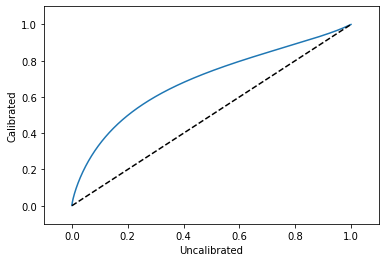

In [53]:
sc10.show_calibration_curve()

In [54]:
sc10.knot_vec, len(sc10.knot_vec)

(array([0.00000000e+00, 7.24496385e-05, 3.86648424e-03, 7.45300840e-02,
        1.00000000e-01, 1.58969584e-01, 2.00000000e-01, 2.26196301e-01,
        2.43937790e-01, 2.57958778e-01, 2.63767686e-01, 2.74823570e-01,
        2.92794031e-01, 3.00000000e-01, 3.04173557e-01, 4.00000000e-01,
        4.08302908e-01, 4.14661940e-01, 4.20353809e-01, 4.32279581e-01,
        4.90966386e-01, 5.00000000e-01, 5.34508940e-01, 6.00000000e-01,
        6.39186899e-01, 7.00000000e-01, 8.00000000e-01, 9.00000000e-01,
        9.90453309e-01, 1.00000000e+00]), 30)

In [55]:
(log_loss(yvec_test, sc8.calibrate(xvec_test)), 
 log_loss(yvec_test, sc9.calibrate(xvec_test)),
 log_loss(yvec_test, sc10.calibrate(xvec_test)))

(0.5034215450761254, 0.5039773750126008, 0.503967473304427)